# Designing a CNN Model for Image Label Prediction

&nbsp;

## 1. Introduction
This is a university project where I am tasked with building a CNN model from scratch and training it on the provided training dataset, so as to be able to predict the labels for the also provided test dataset.

&nbsp;

### 1.1. Objectives
Achieve a test accuracy > 75% on the test predictions.

&nbsp;

### 1.2. Source of the Data
Datasets provided by the University.

&nbsp;

### 1.3. Datasets Description
The file `data_cnnmodel/train_data.npy` includes 10k images, and the file `data_cnnmodel/train_labels.csv` the respective labels for that training dataset.

Additionally, the `data_cnnmodel/test_data.npy` file includes also 10k images as the test set. Unfortunately, the test data labels were not provided to me, having the final test accuracy been evaluated on an online university submission platform.

No more information on the data was given.

&nbsp;

## 2. Importing Libraries and Loading Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR

In [ ]:
# Loading training data
data_train   = np.load('data_cnnmodel/train_data.npy')
labels_train = np.load('data_cnnmodel/train_labels.npy')

In [ ]:
# Labels
np.unique(labels_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

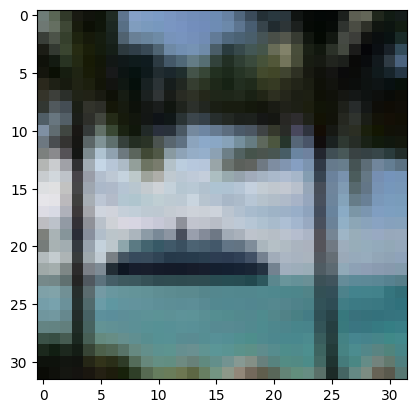

In [ ]:
# Loading random training data example
i = np.random.randint(0, len(data_train))
plt.imshow(data_train[i].reshape(3, 32, 32).transpose(1, 2, 0))
plt.show()

In [ ]:
data_train.shape, labels_train.shape

((10000, 3072), (10000,))

&nbsp;

## 3. Preparing the Data

In [ ]:
# Normalizing the data
data_train = data_train / 255.0


# Creating a validation set
X_train, X_val, y_train, y_val = train_test_split(
    data_train,
    labels_train,
    test_size=0.02,
    random_state=7,
    stratify=labels_train
)


# Creating training and validation datasets and loaders
X_train = torch.tensor(X_train, dtype=torch.float32)
X_train = X_train.view(-1, 3, 32, 32)

X_val = torch.tensor(X_val, dtype=torch.float32)
X_val = X_val.view(-1, 3, 32, 32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

&nbsp;

## 4. Creating and Instantiating the Model

In [ ]:
# Creating the model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)  # each filter gets the shape (3, 3, 3), meaning that each filter will take into account the 3 input channels at the same time, summing the results appropriately and producing one output channel.
        self.bn1 = nn.BatchNorm2d(64)  # we normalize each of the 64 channels to keep the input distribution more stable and allow for higher learning rates and smooth convergence of the algorithm

        # Second convolutional block
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # Third convolutional block
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Fourth convolutional block
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        # ReLU
        self.relu = nn.ReLU(inplace=True)

        # Max pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size=2, stride=2 --> no overlapping of the input features
        self.dropout = nn.Dropout(0.1)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)  # Looking at the forward method, we have an architecture with 3 pooling functions, therefore the width and height get reduced in this way: 32 -> 16 -> 8 -> 4. Therefore, the shape of each batch sample is 512 (channels) * 4 (width) * 4 (height).
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 10)  # 10 output classes

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))  # Conv1 -> BN -> ReLU -> Pool
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.dropout(x)  # Apply dropout after conv blocks
        x = x.view(-1, 512 * 4 * 4)  # Flatten -> Fully connected layers in NN expect a 2D vector as input, but the output of the convolution and pooling layers is a 4D tensor (batch_size, channels, height, width). Therefore we need to flatten the tensor into a 2D vector (batch_size, features).
        x = self.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Dropout in FC layer
        x = self.fc2(x)
        return x


# Instantiating the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

&nbsp;

## 5. Defining the Loss Function and the Model's Hyperparameters

In [ ]:
# Loss function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

&nbsp;

## 6. Training and Evaluation

In [ ]:
# Training and evaluating the model
nr_epochs = 70

for epoch in range(nr_epochs):
    model.train()

    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Evaluating on validation set
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    scheduler.step()

    print(f'Epoch {epoch + 1}/{nr_epochs} --> Training Loss: {running_loss / len(train_loader):.3f} | Accuracy: {accuracy:.2f}%')

Epoch 1/70 --> Training Loss: 1.834 | Accuracy: 48.50%
Epoch 2/70 --> Training Loss: 1.503 | Accuracy: 51.50%
Epoch 3/70 --> Training Loss: 1.369 | Accuracy: 54.00%
Epoch 4/70 --> Training Loss: 1.233 | Accuracy: 64.50%
Epoch 5/70 --> Training Loss: 1.113 | Accuracy: 58.50%
Epoch 6/70 --> Training Loss: 1.012 | Accuracy: 69.00%
Epoch 7/70 --> Training Loss: 0.900 | Accuracy: 67.00%
Epoch 8/70 --> Training Loss: 0.806 | Accuracy: 67.00%
Epoch 9/70 --> Training Loss: 0.724 | Accuracy: 72.00%
Epoch 10/70 --> Training Loss: 0.625 | Accuracy: 71.00%
Epoch 11/70 --> Training Loss: 0.421 | Accuracy: 78.00%
Epoch 12/70 --> Training Loss: 0.314 | Accuracy: 78.50%
Epoch 13/70 --> Training Loss: 0.256 | Accuracy: 73.50%
Epoch 14/70 --> Training Loss: 0.220 | Accuracy: 75.50%
Epoch 15/70 --> Training Loss: 0.197 | Accuracy: 74.00%
Epoch 16/70 --> Training Loss: 0.150 | Accuracy: 76.50%
Epoch 17/70 --> Training Loss: 0.142 | Accuracy: 78.00%
Epoch 18/70 --> Training Loss: 0.117 | Accuracy: 75.50%
E

&nbsp;

## 7. Predictions

In [ ]:
# Function to generate predictions
def predict(model, loader):
    preds = []
    with torch.no_grad():
        for seqs, _ in loader:
            seqs = seqs.to(device)
            outputs = model(seqs)
            _, pred_classes = torch.max(outputs.data, 1)
            preds.extend(pred_classes.squeeze().cpu().numpy())  # squeeze() removes all dimensions of size 1 from the tensor (so, like from (batch_size, 1) to (batch_size))
    return np.array(preds)

# Loading and setting up test data
data_test = np.load('data_cnnmodel/test_data.npy') / 255.0
data_test = torch.tensor(data_test, dtype=torch.float32)
data_test = data_test.view(-1, 3, 32, 32)

test_dataset = TensorDataset(data_test, torch.zeros(len(data_test)))
loader_test = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Predicting
predictions = predict(model, loader_test)

pd.DataFrame(predictions, columns=['prediction']).to_csv('submission.csv')

&nbsp;

## 8. Conclusion
Upon submitting the final predictions file to the online university submission platform, I obtained a pass, which meant that the objective of achieving an accuracy higher than 75% on the test predictions was achieved.